<a href="https://colab.research.google.com/github/GouravDas03/Breast_Cancer_Prediction/blob/main/Breast_Cancer_Prediction_using_CNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import base64
import os, glob
import cv2
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense, MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import Flatten
import PIL
from PIL import Image
from math import exp, tanh
from tokenize import Exponent
from enum import Enum
from io import BytesIO, StringIO
from tensorflow import keras
from keras import layers
from datetime import date
from IPython import display
import uuid
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, mean_absolute_error, mean_squared_error

<ipython-input-1-d30a65cb7449>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook as tqdm


In [ ]:
DATADIR = "/content/Dataset"

In [ ]:
CATEGORIES = ['benign', 'malignant']

In [ ]:
import pathlib

data_dir = pathlib.Path(DATADIR)

In [ ]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

2465


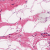

In [ ]:
benign = list(data_dir.glob('benign/*'))
PIL.Image.open(str(benign[0]))

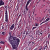

In [ ]:
malignant = list(data_dir.glob('malignant/*'))
PIL.Image.open(str(malignant[0]))

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2465 files belonging to 2 classes.
Using 1972 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2465 files belonging to 2 classes.
Using 493 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['benign', 'malignant']


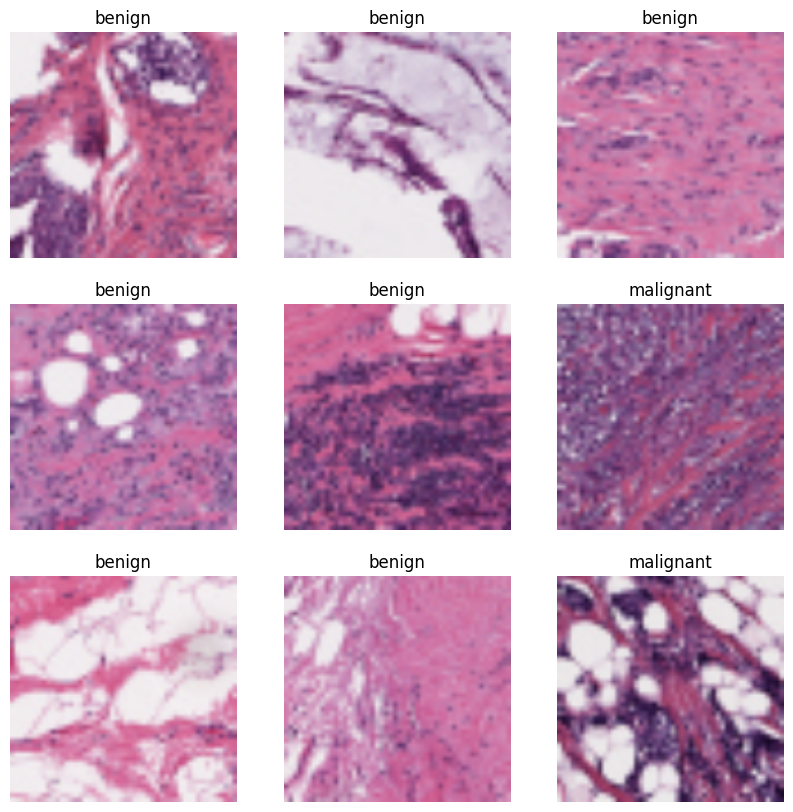

In [ ]:
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

In [ ]:
print(np.min(first_image), np.max(first_image))

0.048130147 0.9301263


In [ ]:
num_classes = len(class_names)

In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal',
                      input_shape=(img_height, img_width,3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


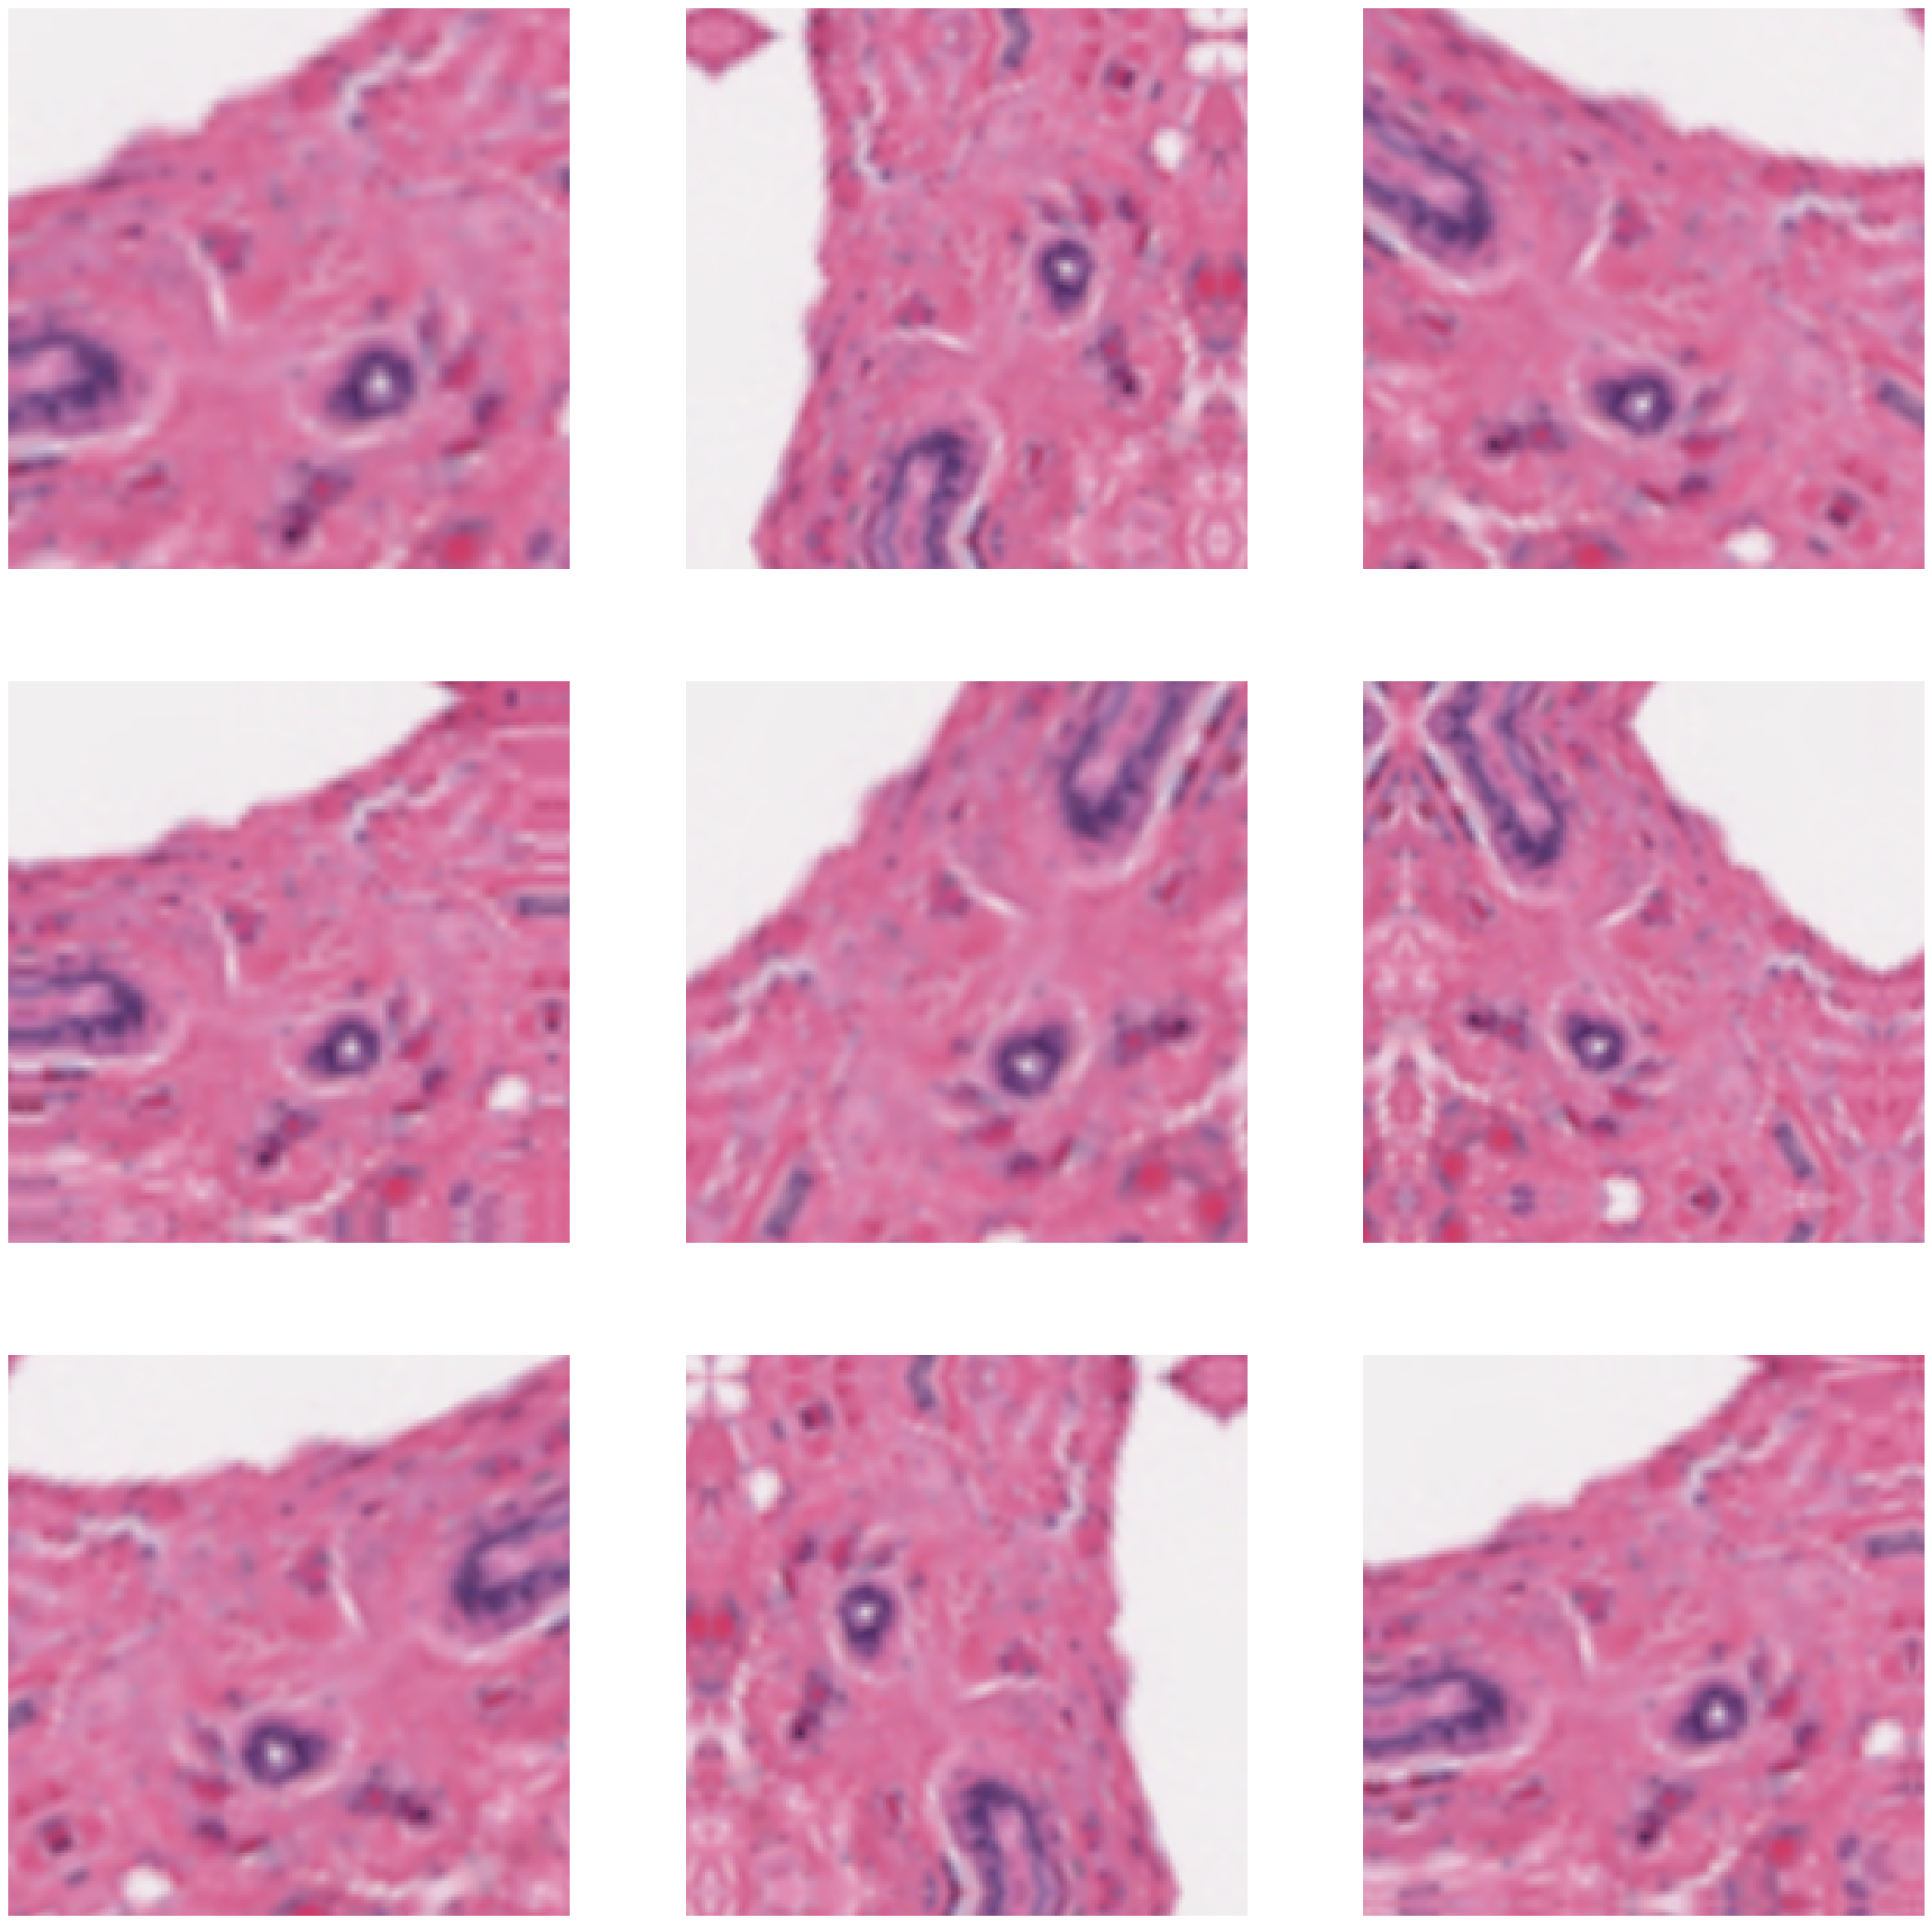

In [ ]:
plt.figure(figsize=(30, 30))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Reshape((64, -1)),
    layers.LSTM(64),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy',])

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=20)

Epoch 1/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.7643 - loss: 0.5348 - val_accuracy: 0.8479 - val_loss: 0.3531
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.8386 - loss: 0.3678 - val_accuracy: 0.8864 - val_loss: 0.3084
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.8809 - loss: 0.3114 - val_accuracy: 0.8884 - val_loss: 0.2942
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.8626 - loss: 0.3330 - val_accuracy: 0.8621 - val_loss: 0.3547
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8812 - loss: 0.3254 - val_accuracy: 0.8905 - val_loss: 0.2945
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.8683 - loss: 0.3188 - val_accuracy: 0.8884 - val_loss: 0.2927
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.8877 - loss: 0.3025 - val_accuracy: 0.8905 - val_loss: 0.2990
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.8728 - loss: 0.3164 - val_accuracy: 0.8783 - v

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

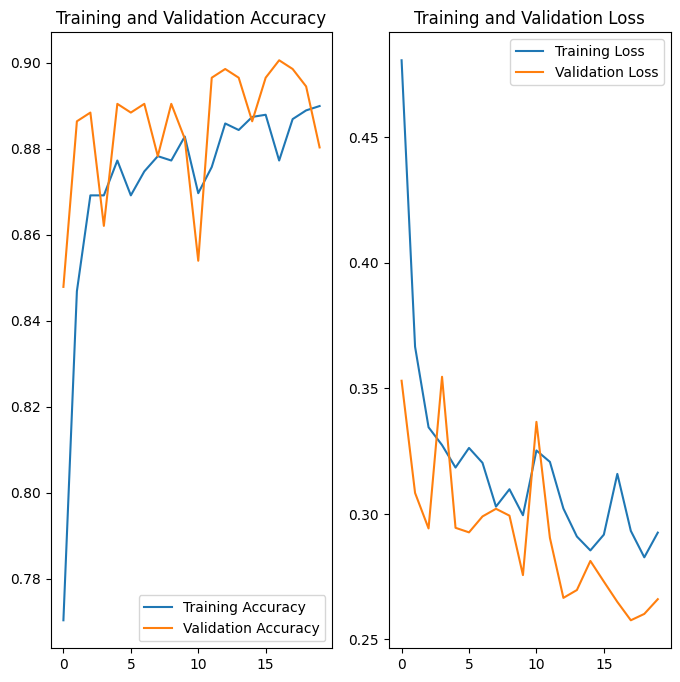

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
DATADIR = '/content/img1.png'

In [ ]:
img = tf.keras.utils.load_img(DATADIR, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

In [ ]:
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print("This image most likely belongs to {}".format(class_names[np.argmax(score)]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
This image most likely belongs to benign


In [ ]:
def calculate_sensitivity_specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    return sensitivity, specificity

In [ ]:
y_true = []
y_pred = []

In [ ]:
for images, labels in val_ds:
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(predicted_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [ ]:
y_true = np.array(y_true)
y_pred = np.array(y_pred)

In [ ]:
sensitivity, specificity = calculate_sensitivity_specificity(y_true, y_pred)

print(f'Sensitivity: {sensitivity:.2f}')
print(f'Specificity: {specificity:.2f}')

Sensitivity: 0.55
Specificity: 0.97


In [ ]:
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

      benign       0.89      0.97      0.93       389
   malignant       0.83      0.55      0.66       104

    accuracy                           0.88       493
   macro avg       0.86      0.76      0.79       493
weighted avg       0.88      0.88      0.87       493



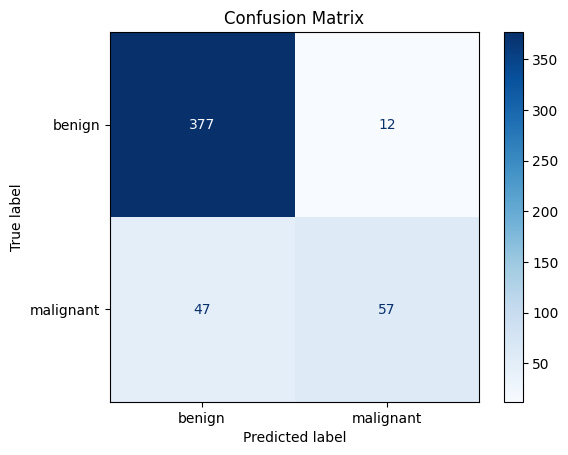

In [ ]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
mae = mean_absolute_error(y_true, y_pred) * 100
rmse = (mean_squared_error(y_true, y_pred, squared=False)) * 100

print(f'Mean Absolute Error (MAE): {mae:.2f}%')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}%')

Mean Absolute Error (MAE): 11.97%
Root Mean Squared Error (RMSE): 34.59%
